# Import library

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy, copy
import functools

In [26]:
import cProfile
import pstats
from multiprocessing import Pool

## Random seed

In [27]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Function to transform the data

In [28]:
# Function to transfer from dBW to W (power)
def db2pow(db: float) -> float:
    return 10**(db/10)

# Function to transfer from W to dBW (power)
def pow2db(pow: float) -> float:
    return 10*np.log10(pow)

# Hermitian transpose of a matrix
def HermTranspose(x: np.ndarray) -> np.ndarray:
    return x.conj().T

def chanGen(zeta: float, d: float, dim1: int, dim2: int) -> np.ndarray:
    """Function to generate Rayleigh fading channel coefficients

    Args:
        zeta: ξ is the path loss exponent
        d: the distance between the transmitter and the receiver
        dim1: the number of rows in the channel matrix
        dim2: the number of columns in the channel matrix
    """
    pl_ref: float = -30                                    # pathloss (dBW) at reference distance
    pl: float = db2pow(pl_ref - 10*zeta*np.log10(d))       # pathloss model at distance d
    y: np.ndarray = np.sqrt(0.5*pl)*(np.random.randn(dim1,dim2)\
        + 1j*np.random.randn(dim1,dim2))            # Rayleigh distribution
    return y

## Parameters

In [29]:
sigma = db2pow(-75)                                                                 # noise power
N = 8                                                                               # number of transmit antennas
Nris = 32                                                                           # number of RIS elements
number_of_users = 4                                                                 # number of users
number_of_eavesdroppers = 2                                                         # number of eavesdroppers
zetaAI = 2.2                                                                        # Path loss exponent of the channel between the Alice and the RIS
zetaIB = 2.5                                                                        # Path loss exponent of the channel between the legitimate receivers and the RIS
zetaIE = 2.5                                                                        # Path loss exponent of the channel between the eavesdroppers and the RIS
zetaAB = 3.5                                                                        # Path loss exponent of the channel between the Alice and the legitimate receivers
zetaAE = 3.5                                                                        # Path loss exponent of the channel between the Alice and the eavesdroppers

dAI = 50                                                                            # distance between Alice and the RIS
dv = 2                                                                              # Vertical distance between the Alice and the Eve and Bob
dABh = np.random.uniform(5, 10, size=number_of_users)                               # Horizontal distance between Alice and the legitimate receivers
dAEh = np.random.uniform(50, 150, size=number_of_eavesdroppers)                     # Horizontal distance between Alice and the eavesdroppers
dAB = [np.sqrt(dABh[i]**2 + dv**2) for i in range(number_of_users)]                 # Distance between Alice and the legitimate receivers
dAE = [np.sqrt(dAEh[i]**2 + dv**2) for i in range(number_of_eavesdroppers)]         # Distance between Alice and the eavesdroppers
dIB = [np.sqrt((dABh[i]-dAI)**2 + dv**2) for i in range(number_of_users)]           # Distance between the legitimate receivers and the RIS
dIE = [np.sqrt((dAEh[i]-dAI)**2 + dv**2) for i in range(number_of_eavesdroppers)]   # Distance between the eavesdroppers and the RIS


In [30]:
def normalise_beamforming_vectors(w: np.ndarray) -> np.ndarray:
    """Function to normalise the beamforming vectors

    Args:
        w: the beamforming vectors
    """
    total_norm = 0
    for i in range(number_of_users):
        total_norm += np.linalg.norm(w[i])
    for i in range(number_of_users):
        w[i] = w[i] / total_norm
    return w

def generate_random_beamforming_vector():
  '''
  Generate one random beamforming vector
  '''
  return np.random.uniform(-1, 1, (N, 1)) + 1j * np.random.uniform(-1, 1, (N, 1))

def generate_random_beamforming_vectors():
    # Generate random complex numbers for each element of the beamforming vector
    beamforming_vectors = [generate_random_beamforming_vector() for _ in range (number_of_users)]
    
    # Normalize the vectors
    beamforming_vectors = normalise_beamforming_vectors(beamforming_vectors)
    return beamforming_vectors
    #w: list of beamforming vectors, length = number of users, elements are N x 1

def generate_random_theta():
    theta = np.random.uniform(-np.pi, np.pi, (1, Nris))
    theta = np.exp(1j * theta)
    return theta
    #theta: phase shift of RIS, size 1 x Nris

def generate_random_theta_angles(size: int):
  """
    Generate a random vector of angles from -pi to pi
  """
  return np.random.uniform(-np.pi, np.pi, size=(1, size))

def theta_angles_to_theta_vector(angles: np.ndarray[np.float64]) -> np.ndarray[np.complex128]:
  """
    Convert a vector of angles to a vector of complex numbers on the unit circle
  """
  return np.exp(1j * angles)

def theta_vector_to_theta_angles(theta: np.ndarray[np.complex128]) -> np.ndarray[np.float64]:
  """
    Convert a vector of complex numbers on the unit circle to a vector of angles
  """
  return np.angle(theta)

def generateChannel():
    normFact = 1/np.sqrt(sigma)
    Hai = chanGen(zetaAI, dAI, Nris, N)                                                         # Alice to RIS channel
    hib = [normFact*chanGen(zetaIB, dIB[i], 1, Nris) for i in range(number_of_users)]           # Channel between the RIS and the legitimate receivers
    hie = [normFact*chanGen(zetaIE, dIE[i], 1, Nris) for i in range(number_of_eavesdroppers)]   # Channel between the RIS and the eavesdroppers
    hab = [normFact*chanGen(zetaAB, dAB[i], 1, N) for i in range(number_of_users)]              # Channel between Alice and the legitimate receivers
    hae = [normFact*chanGen(zetaAE, dAE[i], 1, N) for i in range(number_of_eavesdroppers)]      # Channel between Alice and the eavesdroppers
    return Hai, hib, hie, hab, hae

    #Hai: Channel between Alice and RIS: Nris x N  
    #hib: Channel between RIS and users: List of length number_of_users, elements are 1 x Nris
    #hab: Channel between Alice and users: List of length number_of_users, elements are 1 x N
    #hie: Channel between RIS and eavesdroppers: List of length number_of_eavesdroppers, elements are 1 x Nris
    #hae: Channel between Alice and eavesdroppers: List of length number_of_eavesdroppers, elements are 1 x N

In [31]:
# Reseed
# np.random.seed(RANDOM_SEED)

# Channel generation
Hai, hib, hie, hab, hae = generateChannel()

# Generate random theta and w
theta_init = generate_random_theta()
w_init = generate_random_beamforming_vectors()

# Objective Function

In [32]:
def secrecy_rate_objective_function(theta, w) -> float:
    secrecy_rate: float = 0
    for k in range(number_of_users):
        R_bk = []
        # Legitimate user k
        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk
        C_bk = np.log2(1 + gamma_bk)
        
        for m in range(number_of_eavesdroppers):
            # Eavesdropper i
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            C_em = np.log2(1 + gamma_em)
            R_bk.append(C_bk - C_em)
        
        secrecy_rate += max(min(R_bk),0)

    # Return the only element in the matrix as it is currently a 1x1 np array
    return secrecy_rate[0, 0]

In [33]:
# print(theta_init)
print("distance between Alice and the receivers: ", dAB)
print("distance between Alice and the eavesdroppers: ", dAE)
print("Secrecy Rate:", secrecy_rate_objective_function(theta_init, w_init))

distance between Alice and the receivers:  [np.float64(7.157793896028513), np.float64(9.956513327003986), np.float64(8.887917380454502), np.float64(8.23970410435831)]
distance between Alice and the eavesdroppers:  [np.float64(65.63234390206881), np.float64(65.62993301163156)]
Secrecy Rate: 1.402871877074606


# Method

## Gradient Descent for Maximization (GD)

In [34]:
def compute_gradient_w(theta, w):
    grad_w = []
    Z_e_max = [] #Z_e_max[k] = Z_e_max for user k
    gamma_e_max = [] #gamma_e_max[k] = gamma_e_max for user k
    Z_b = [] #Z_b[k] = Z_bk
    gamma_b = [] #gamma_b[k] = gamma_bk
    counted = [] #counted[k] = true if gamma_k > gamma_e_max[k]
    
    #Precalculation 
    for k in range(number_of_users):
        gamma_e = []
        for m in range (number_of_eavesdroppers):
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            gamma_e.append(gamma_em)
        
        gamma_e_max.append(max(gamma_e))
        index_e_max = gamma_e.index(max(gamma_e))
        Z_e = hie[index_e_max] @ np.diag(theta.flatten()) @ Hai + hae[index_e_max]
        Z_e_max.append(Z_e)

        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk

        Z_b.append(Z_bk)
        gamma_b.append(gamma_bk)

        counted.append(gamma_bk > gamma_e[index_e_max])


    #Calculating grad for i-th beamforming vector
    for i in range(number_of_users):
        grad = np.zeros((N, 1))
        #print("grad_shape =", grad.shape)
        for k in range (number_of_users):
            if (counted[k] == False):
                continue
            if (k == i):
                num_grad_C_bk_to_w_k = 2 * (HermTranspose(Z_b[k]) @ Z_b[k] @ w[k])
                den_grad_C_bk_to_w_k = (1 + gamma_b[k]) * np.log(2) * (1 + sum([abs(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k]))
                grad_C_bk_to_w_k = num_grad_C_bk_to_w_k / den_grad_C_bk_to_w_k

                num_grad_C_e_max_to_w_k = 2 * (HermTranspose(Z_e_max[k]) @ Z_e_max[k] @ w[k])
                den_grad_C_e_max_to_w_k = (1 + gamma_e_max[k]) * np.log(2) * (1 + sum([abs(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k]))
                grad_C_e_max_to_w_k = num_grad_C_e_max_to_w_k / den_grad_C_e_max_to_w_k
                
                #print("num_grad_C_e_max_to_w_k", num_grad_C_e_max_to_w_k.shape)
                #print("den_grad_C_e_max_to_w_k", den_grad_C_e_max_to_w_k.shape)
                grad = grad - (grad_C_bk_to_w_k - grad_C_e_max_to_w_k)
            else:
                num_grad_C_bk_to_w_i = -2 * abs(Z_b[k] @ w[k]) * (HermTranspose(Z_b[k]) @ Z_b[k] @ w[i])
                den_grad_C_bk_to_w_i = (1 + gamma_b[k]) * np.log(2) * (1 + sum([abs(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k])) ** 2
                grad_C_bk_to_w_i = num_grad_C_bk_to_w_i / den_grad_C_bk_to_w_i

                num_grad_C_e_max_to_w_i = -2 * abs(Z_e_max[k] @ w[k]) * (HermTranspose(Z_e_max[k]) @ Z_e_max[k] @ w[i])
                den_grad_C_e_max_to_w_i = (1 + gamma_e_max[k]) * np.log(2) * (1 + sum([abs(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k])) ** 2
                grad_C_e_max_to_w_i = num_grad_C_e_max_to_w_i / den_grad_C_e_max_to_w_i

                grad = grad - (grad_C_bk_to_w_i - grad_C_e_max_to_w_i)
            
        grad_w.append(grad)
    return grad_w

def compute_gradient_theta_central(theta, w, epsilon=1e-3):
    perturbation = epsilon + epsilon * 1j
    grad_theta = []
    for i in range(Nris):
        theta_plus = copy(theta)
        theta_plus[0, i] += perturbation
        theta_minus = copy(theta)
        theta_minus[0, i] -= perturbation
        grad_theta_i = (secrecy_rate_objective_function(theta_plus, w) - secrecy_rate_objective_function(theta_minus, w)) / (2*epsilon)
        grad_theta.append(grad_theta_i)
            
    return np.array(grad_theta)

def compute_gradient_theta(theta, w, original_secrecy_rate=None, epsilon=1e-3):
    """
    Faster implementation of the gradient calculation

    Improvements:
    - Use forward difference instead of central difference
    """
    perturbation = epsilon + epsilon * 1j
    grad_theta = []
    for i in range(Nris):
        theta_plus = copy(theta)
        theta_plus[0, i] += perturbation
        grad_theta_i = (secrecy_rate_objective_function(theta_plus, w) - original_secrecy_rate) / epsilon
        grad_theta.append(grad_theta_i)

    return np.array(grad_theta)


def gradient_descent_update(w, theta, learning_rate, original_secrecy_rate=None):
    grad_w = compute_gradient_w(theta, w)
    grad_theta = compute_gradient_theta(theta, w, original_secrecy_rate)
    w_new = [w[i] - learning_rate * grad_w[i] for i in range (number_of_users)]
    total_norm = 0
    for i in range (number_of_users):
        total_norm += np.linalg.norm(w_new[i])
    for i in range (number_of_users):
        w_new[i] = w_new[i] / total_norm
        
    theta_new = theta - learning_rate * grad_theta
    theta_new = np.exp(1j * np.angle(theta_new))

    return w_new, theta_new

In [35]:
# Reseed first
np.random.seed(RANDOM_SEED)

# Gradient Descent Algorithm
num_cycles = 500
learning_rate = 0.01
theta_GD = generate_random_theta()
w_GD = generate_random_beamforming_vectors()
print("Initial Secrecy Rate GD:", secrecy_rate_objective_function(theta_GD, w_GD))
current_secrecy_rate = secrecy_rate_objective_function(theta_init, w_init)

GD_results = []
GD_results.append(current_secrecy_rate)

for i in range(num_cycles):
    w_new, theta_new = gradient_descent_update(w_GD, theta_GD, learning_rate, original_secrecy_rate=current_secrecy_rate)
    new_secrecy_rate = secrecy_rate_objective_function(theta_new, w_new)
    # print(new_secrecy_rate)
    if (new_secrecy_rate - current_secrecy_rate) < 1e-9:
        print("Converged")
        break
    w_GD = w_new
    theta_GD = theta_new
    GD_results.append(new_secrecy_rate)
    current_secrecy_rate = new_secrecy_rate

print(GD_results)
print("Final Secrecy Rate GD:", secrecy_rate_objective_function(theta_GD, w_GD))

Initial Secrecy Rate GD: 0.8491449368663513
Converged
[np.float64(1.402871877074606), np.float64(3.584832378879026), np.float64(5.445804074834887), np.float64(6.2661648113131045), np.float64(6.6984086898372395), np.float64(7.011026760832104), np.float64(7.271851049675291), np.float64(7.487843958204171), np.float64(7.657187544486945), np.float64(7.784660180926572), np.float64(7.878776666822533), np.float64(7.947887788004143), np.float64(7.998735146322263), np.float64(8.036345512486172), np.float64(8.064349030737437), np.float64(8.085341076421804), np.float64(8.101178210266703), np.float64(8.113195953617375), np.float64(8.12236258465163), np.float64(8.12938617731758), np.float64(8.134788950030341), np.float64(8.138959140054148), np.float64(8.142187486601523), np.float64(8.14469313721233), np.float64(8.146642229606423), np.float64(8.14816135190212), np.float64(8.149347384254108), np.float64(8.150274757010122), np.float64(8.151000845604496), np.float64(8.151570008727408), np.float64(8.1520

## Particle Swarm Optimization (PSO)

In [36]:
class PSOParticle:
  def __init__(self) -> None:
    self.theta = generate_random_theta_angles(Nris)
    self.w = generate_random_beamforming_vectors()
    self.best_theta = deepcopy(self.theta)
    self.best_w = deepcopy(self.w)
    self.best_secrecy_rate = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.best_theta), self.best_w)
    self.velocity_theta = np.zeros((1, Nris))
    self.velocity_w = [np.zeros((N, 1)) for i in range(number_of_users)]

  def update_velocity(self, inertia, c1, c2, global_best_theta, global_best_w):
    r1 = np.random.rand()
    r2 = np.random.rand()
    self.velocity_theta = inertia * self.velocity_theta + c1 * r1 * (self.best_theta - self.theta) + c2 * r2 * (global_best_theta - self.theta)
    self.velocity_w = [inertia * self.velocity_w[i] + c1 * r1 * (self.best_w[i] - self.w[i]) + c2 * r2 * (global_best_w[i] - self.w[i]) for i in range(number_of_users)]

  def update_position(self):
    self.theta = self.theta + self.velocity_theta
    self.w = [self.w[i] + self.velocity_w[i] for i in range(number_of_users)]
    total_norm = 0
    for i in range (number_of_users):
        total_norm += np.linalg.norm(self.w[i])
    for i in range(number_of_users):
        self.w[i] = self.w[i] / total_norm

  def update_velocity_theta(self, inertia, c1, c2, global_best_theta): #Used for PSO_GD
    self.velocity_theta = inertia * self.velocity_theta + c1 * np.random.rand() * (self.best_theta - self.theta) + c2 * np.random.rand() * (global_best_theta - self.theta)
  
  def update_position_theta(self): #Used for PSO_GD
    self.theta = self.theta + self.velocity_theta

  def update_best(self):
    current_secrecy_rate = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.theta), self.w)
    if current_secrecy_rate > self.best_secrecy_rate:
      self.best_secrecy_rate = current_secrecy_rate
      self.best_theta = deepcopy(self.theta)
      self.best_w = deepcopy(self.w)

In [37]:
def dynamic_inertia(i: int, max_iter: int, inertia_max: float, inertia_min: float) -> float:
  E_t = float((max_iter - i - 1)/max_iter)
  inertia = inertia_min + (inertia_max - inertia_min) * (2 /(1 + (np.e ** (-5 * E_t))) - 1)
  return inertia

In [38]:
def PSO_optimize_w_theta(max_iter: int, num_particles: int, w_min: float, w_max: float, c1: float, c2: float):
  particles = [PSOParticle() for _ in range(num_particles)]
  global_best_secrecy_rate = -np.inf
  global_best_theta = np.zeros((1, Nris))
  global_best_w = [np.zeros((N, 1)) for i in range(number_of_users)]

  results_secrecy_rate = []

  for particle in particles:
    if particle.best_secrecy_rate > global_best_secrecy_rate:
      global_best_secrecy_rate = particle.best_secrecy_rate
      global_best_theta = deepcopy(particle.best_theta)
      global_best_w = deepcopy(particle.best_w)

  results_secrecy_rate.append(global_best_secrecy_rate)

  for iteration in range(max_iter):
    inertia = dynamic_inertia(iteration, max_iter, w_max, w_min)

    for particle in particles:
      particle.update_velocity(inertia, c1, c2, global_best_theta, global_best_w)
      particle.update_position()
      particle.update_best()

      if particle.best_secrecy_rate > global_best_secrecy_rate:
        global_best_secrecy_rate = particle.best_secrecy_rate
        global_best_theta = deepcopy(particle.best_theta)
        global_best_w = deepcopy(particle.best_w)

    results_secrecy_rate.append(global_best_secrecy_rate)

  return results_secrecy_rate

In [39]:
# Reseed
np.random.seed(RANDOM_SEED)

# PSO Algorithm
max_iter = 500
num_particles = 100
w_min = 0.5
w_max = 0.9
c1 = 1.5
c2 = 1.5

PSO_results = PSO_optimize_w_theta(max_iter, num_particles, w_min, w_max, c1, c2)
print("Initial Secrecy Rate PSO:", PSO_results[0])
print(PSO_results)
print("Final Secrecy Rate PSO:", PSO_results[-1])

Initial Secrecy Rate PSO: 2.555785015476292
[np.float64(2.555785015476292), np.float64(5.236534463565515), np.float64(6.052684715089867), np.float64(6.0823367089755465), np.float64(6.486696302455856), np.float64(6.657821243754506), np.float64(6.893691344047821), np.float64(7.011052212577392), np.float64(7.148130506231335), np.float64(7.240330333781451), np.float64(7.321746145511387), np.float64(7.432775971428741), np.float64(7.542894460636593), np.float64(7.661240577081576), np.float64(7.743286504793807), np.float64(7.7752572522426044), np.float64(7.815101937555166), np.float64(7.863831200319168), np.float64(7.8801429977285675), np.float64(7.900839868626552), np.float64(7.935937032864098), np.float64(7.9719045462205145), np.float64(7.97409536613994), np.float64(7.983840108641708), np.float64(7.9941797803654575), np.float64(7.9941797803654575), np.float64(7.995027995751797), np.float64(8.00236363010428), np.float64(8.010642690321331), np.float64(8.049032877015266), np.float64(8.08598812

## Genetic Algorithm (GA)

In [40]:
class GAIndividual:
  def __init__(self, theta: np.ndarray[np.float64] = None, w: np.ndarray[np.complex128] = None) -> None:
    if theta is None:
      self.theta = generate_random_theta_angles(Nris)
    else:
      self.theta = theta

    if w is None:
      self.w = generate_random_beamforming_vectors()
    else:
      self.w = w

    self.update_fitness()

  def update_fitness(self):
    self.fitness = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.theta), self.w)


class GAPopulation:
  def __init__(self, population_size: int, crossover_rate: float = 0.85, mutation_rate: float = 0.3) -> None:
    self.population_size = population_size
    self.individuals = [GAIndividual() for _ in range(population_size)]
    self.crossover_rate = crossover_rate
    self.mutation_rate = mutation_rate

  def sort_population(self):
    self.individuals.sort(key=lambda x: x.fitness, reverse=True)

  def filter_population(self):
    self.sort_population()
    self.individuals = self.individuals[:self.population_size]

  def add_individual(self, individual: GAIndividual):
    self.individuals.append(individual)

  def select_parents(self) -> tuple[GAIndividual, GAIndividual]:
    parents = np.random.choice(self.individuals, 2, replace=False)
    return parents[0], parents[1]
  
  def crossover(self, parent1: GAIndividual, parent2: GAIndividual) -> GAIndividual:
    theta1, w1 = parent1.theta, parent1.w
    theta2, w2 = parent2.theta, parent2.w
    theta_child = (theta1 + theta2) / 2
    w_child = [(w1[i] + w2[i]) / 2 for i in range(number_of_users)]
    return GAIndividual(theta_child, w_child)
  
  def mutate(self, individual: GAIndividual) -> GAIndividual:
    if np.random.rand() < self.mutation_rate:
      mutation_index = np.random.randint(0, Nris)
      individual.theta[0, mutation_index] = np.random.uniform(-np.pi, np.pi)
      mutation_index = np.random.randint(len(individual.w))
      individual.w[mutation_index] = generate_random_beamforming_vector()
      individual.w = normalise_beamforming_vectors(individual.w)
      individual.update_fitness()

    return individual
  
def GA_optimize_w_theta(population_size: int, max_iter: int, crossover_rate: float = 0.85, mutation_rate: float = 0.85):
  population = GAPopulation(population_size, crossover_rate, mutation_rate)
  population.sort_population()
  results_secrecy_rate = []
  results_secrecy_rate.append(population.individuals[0].fitness)

  for _ in range(max_iter):
    # Crossover
    for _ in range(population_size):
      if np.random.rand() < population.crossover_rate:
        parent1, parent2 = population.select_parents()
        child = population.crossover(parent1, parent2)
        population.mutate(child)
    #Mutate 
        population.add_individual(child)

    # Filter
    population.filter_population()

    results_secrecy_rate.append(population.individuals[0].fitness)

  return results_secrecy_rate

In [41]:
population_size = 100
num_generations = 500
crossover_rate = 0.9
mutation_rate = 0.3

# Reseed
np.random.seed(RANDOM_SEED)

# GA Algorithm
GA_results = GA_optimize_w_theta(population_size, num_generations, crossover_rate, mutation_rate)
print("Initial Secrecy Rate GA:", GA_results[0])
print(GA_results)
print("Final Secrecy Rate GA:", GA_results[-1])

Initial Secrecy Rate GA: 2.555785015476292
[np.float64(2.555785015476292), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.8260820529384505), np.float64(5.930611612264281), np.float64(5.930611612264281), np.float64(5.9547584096312836), np.float64(5.9547584096312836), np.float64(5.9547584096312836), np.float64(5.9547584096312836), np.float64(5.9547584096312836), np.float64(6.149723019071719), 

In [42]:
def gradient_descent_update_w_only(w, theta, learning_rate):
    grad_w = compute_gradient_w(theta, w)
    w_new = [w[i] - learning_rate * grad_w[i] for i in range (number_of_users)]
    w_new = normalise_beamforming_vectors(w_new)
    theta_new = theta

    return w_new, theta_new

## Combination of PSO and GD

In [20]:
def PSO_GD(max_pso_iter, max_gd_iter, number_of_particles, learning_rate, w_max, w_min, c1, c2):
    particles = [PSOParticle() for _ in range(number_of_particles)]
    global_best_secrecy_rate = -np.inf
    global_best_theta = np.zeros((1, Nris))
    global_best_w = [np.zeros((N, 1)) for i in range(number_of_users)]

    results_secrecy_rate = []

    for particle in particles:
        if particle.best_secrecy_rate > global_best_secrecy_rate:
            global_best_secrecy_rate = particle.best_secrecy_rate
            global_best_theta = deepcopy(particle.best_theta)
            global_best_w = deepcopy(particle.best_w)

    results_secrecy_rate.append(global_best_secrecy_rate)
    
    for iteration in range(max_pso_iter):
        inertia = dynamic_inertia(iteration, max_iter, w_max, w_min)

        """
            Update particles theta by velocity
        """
        for particle in particles:
            particle.update_velocity_theta(inertia, c1, c2, global_best_theta)
            particle.update_position_theta()
            particle.update_best()

            if particle.best_secrecy_rate > global_best_secrecy_rate:
                global_best_secrecy_rate = particle.best_secrecy_rate
                global_best_theta = deepcopy(particle.best_theta)
                global_best_w = deepcopy(particle.best_w)
        """
            Gradient descent w for every particles
        """
        
        for particle in particles:
            for _ in range (max_gd_iter):
                new_w, new_theta = gradient_descent_update_w_only(particle.w, theta_angles_to_theta_vector(particle.theta), learning_rate)
                particle.w = new_w
                particle.theta = theta_vector_to_theta_angles(new_theta)
                particle.update_best()

            if particle.best_secrecy_rate > global_best_secrecy_rate:
                global_best_secrecy_rate = particle.best_secrecy_rate
                global_best_theta = deepcopy(particle.best_theta)
                global_best_w = deepcopy(particle.best_w)

        results_secrecy_rate.append(global_best_secrecy_rate)

    return results_secrecy_rate

In [21]:
# Reseed
np.random.seed(RANDOM_SEED)

max_pso_iter = 500
max_gd_iter = 50
number_of_particles = 100
w_max = 0.9
w_min = 0.5
c1 = 1.5
c2 = 1.5

PSO_GD_results = PSO_GD(max_pso_iter, max_gd_iter, number_of_particles, learning_rate, w_max, w_min, c1, c2)
print("Initial Secrecy Rate PSO-GD:", PSO_GD_results[0])
print("Final Secrecy Rate PSO-GD:", PSO_GD_results[-1])

KeyboardInterrupt: 

## Combination of GA and GD

In [63]:
def GA_GD_optimize_w_theta(population_size: int, max_iter: int, max_iter_gd: int, crossover_rate: float = 0.85, mutation_rate: float = 0.85):
  population = GAPopulation(population_size, crossover_rate, mutation_rate)
  population.sort_population()
  results_secrecy_rate = []
  results_secrecy_rate.append(population.individuals[0].fitness)

  for iteration in range(max_iter):
    # Crossover
    for _ in range(population_size):
      if np.random.rand() < population.crossover_rate:
        parent1, parent2 = population.select_parents()
        child = population.crossover(parent1, parent2)
        population.mutate(child)
    #Mutate 
        population.add_individual(child)

    # Filter
    population.filter_population() 

    print(f"[Generation {iteration + 1}] Population before GD: {list(map(lambda x: x.fitness, population.individuals))}")

    # GD
    for individual in population.individuals:
      for _ in range(max_iter_gd):
        # Gradient Descent for w only
        new_w, new_theta = gradient_descent_update_w_only(individual.w, theta_angles_to_theta_vector(individual.theta), learning_rate)
        new_secrecy_rate = secrecy_rate_objective_function(new_theta, new_w)
        if (new_secrecy_rate - individual.fitness) < 1e-9:
          break

        individual.w = new_w
        individual.theta = theta_vector_to_theta_angles(new_theta)
        individual.update_fitness()
        
    # Sort
    population.sort_population()
    
    print(f"[Generation {iteration + 1}] Population after GD: {list(map(lambda x: x.fitness, population.individuals))}")

    results_secrecy_rate.append(population.individuals[0].fitness)

  return results_secrecy_rate

In [65]:
# Reseed
np.random.seed(RANDOM_SEED)

# GA-GD
population_size = 100
num_generations = 50
num_iter_gd = 10
crossover_rate = 0.9
mutation_rate = 0.3

GA_GD_results = GA_GD_optimize_w_theta(population_size, num_generations, num_iter_gd, crossover_rate, mutation_rate)
print("Initial Secrecy Rate GA-GD:", GA_GD_results[0])
# print(GA_GD_results)
print("Final Secrecy Rate GA-GD:", GA_GD_results[-1])

[Generation 1] Population before GD: [np.float64(5.8260820529384505), np.float64(4.896846379400841), np.float64(4.304518742635426), np.float64(4.182799612471553), np.float64(4.155559027560523), np.float64(3.608267224825826), np.float64(2.9619437306548466), np.float64(2.919960464037066), np.float64(2.7154028279585822), np.float64(2.626624332657613), np.float64(2.564438906901528), np.float64(2.555785015476292), np.float64(2.4342610538474094), np.float64(2.275472670345539), np.float64(2.231514718184522), np.float64(2.150860330633113), np.float64(2.077636656587372), np.float64(2.075101224365044), np.float64(2.0714452648187125), np.float64(2.0514276443812074), np.float64(2.006312385991273), np.float64(1.967135688729386), np.float64(1.9437301807373097), np.float64(1.9437002544698947), np.float64(1.9054482733160119), np.float64(1.8964271243131599), np.float64(1.8891661765549124), np.float64(1.8521823748430826), np.float64(1.8449596763174323), np.float64(1.8264909069825432), np.float64(1.82640

In [54]:
GA_GD_results

[np.float64(2.555785015476292),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.8260820529384505),
 np.float64(5.930611612264281),
 np.float64(5.930611612264281),
 np.float64(5.9547584096312836),
 np.float64(5.9547584096312836),
 np.float64(5.9547584096312836),
 np.float64(5.9547584096312836),
 np.float64(5.9547584096312836),
 np.float64(6.149723019071719),
 np.float64(6.

# Plot diagram

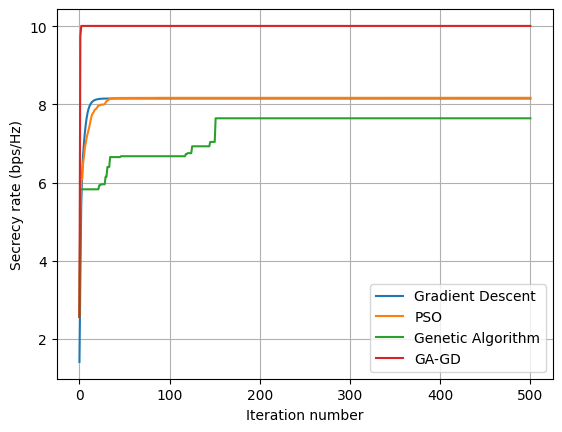

In [66]:
# iterations = range(0, num_cycles+10, 10)

iterations = range(0, max_iter+1)

# Extend the results to the same length
GD_results_draw = GD_results + [GD_results[-1]] * (max_iter + 1 - len(GD_results))
PSO_results_draw = PSO_results + [PSO_results[-1]] * (max_iter + 1 - len(PSO_results))
GA_results_draw = GA_results + [GA_results[-1]] * (max_iter + 1 - len(GA_results))

# PSO_GD_results_draw = [PSO_GD_results[0]]
# for i in range(1, len(PSO_GD_results)):
#     PSO_GD_results_draw.extend([PSO_GD_results[i]] * (max_iter // (len(PSO_GD_results) - 1)))

GA_GD_results_draw = GA_GD_results + [GA_GD_results[-1]] * (max_iter + 1 - len(GA_GD_results))


plt.plot(iterations, GD_results_draw, label='Gradient Descent')
plt.plot(iterations, PSO_results_draw, label='PSO')
plt.plot(iterations, GA_results_draw, label='Genetic Algorithm')
# plt.plot(iterations, PSO_GD_results_draw, label='PSO-GD')
plt.plot(iterations, GA_GD_results_draw, label='GA-GD')

plt.xlabel('Iteration number')
plt.ylabel('Secrecy rate (bps/Hz)')
plt.grid(True)
plt.legend()
plt.show()


In [31]:
# Best results of each methods
print("Best Secrecy Rate GD:", max(GD_results))
print("Best Secrecy Rate PSO:", max(PSO_results))
print("Best Secrecy Rate GA:", max(GA_results))
print("Best Secrecy Rate PSO-GD:", max(PSO_GD_results))

Best Secrecy Rate GD: 13.103861400800648
Best Secrecy Rate PSO: 9.309463922566366
Best Secrecy Rate GA: 18.215249810019525
Best Secrecy Rate PSO-GD: 13.111436313762347
